# Memory and Diffusion
> From Memorization to Generalization with Diffusion Models

<a target="_blank" href="https://colab.research.google.com/github/bhoov/amtutorial/blob/main/tutorial_ipynbs/02_diffusion_as_memory.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook is a simplified, step-by-step walkthrough of the 2D toy example from the paper: ["Memorization to Generalization: Emergence of Diffusion Models from Associative Memory"]((https://arxiv.org/abs/2505.21777)).

We will train a score-based diffusion model on a small dataset of points lying on a circle. Our goal is to understand how the model learns the data distribution and to visualize its learned "energy landscape," which reveals how it behaves like an Associative Memory system initially to later transition into a generative model.

For more details, please read the [paper](https://arxiv.org/abs/2505.21777) and the [code repository](https://github.com/Lemon-cmd/Diffusion-Models-and-Associative-Memory/tree/main).


In [1]:
#| code-fold: true
#| code-summary: "Imports and Setup"
# --- Essential Libraries ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from itertools import cycle
from PIL import Image

from copy import deepcopy

# --- SciPy for specific math functions ---
from scipy.special import i0, i1 # Modified Bessel functions for analytical energy
import scipy.integrate as integrate # For ODE solving (likelihood calculation)

# --- Scikit-learn for Clustering ---
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D

# Set a nice plot style
sns.set_theme(style="whitegrid")

# turn off warnings
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict

In [2]:
#| code-fold: true
#| code-summary: "Caching models"
# For caching trained models
from pathlib import Path
CACHE_DIR = Path("./cache/02_diffusion_as_memory")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
CACHE_MODELS = True

## Data Generation and Visualization

The paper uses a simple dataset: points sampled from the circumference of a unit circle. This helps us easily visualize how the model learns.

We'll define a function to generate these points and a PyTorch `Dataset` class to handle them.

In [3]:
def generate_circle_data(num_samples=60_000, radius=1, seed=59):
    """Generates data points that lie on a unit circle."""
    np.random.seed(seed)
    # Sample angles uniformly from 0 to 2*pi
    angles = np.random.uniform(0, 2 * np.pi, num_samples)

    # Convert polar coordinates (angles, radius) to Cartesian (x, y)
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    return np.stack([x, y], axis=1)

class CircleDataset(Dataset):
    """A PyTorch Dataset to wrap our circle data."""
    def __init__(self, num_samples=60_000, radius=1, seed=9):
        # Generate and store the data as a torch tensor
        self.data = torch.from_numpy(generate_circle_data(num_samples, radius, seed)).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def create_subset(dataset, sample_size, seed=42):
    """Create a subset of the dataset based on the specified sample size. """
    max_size = len(dataset)
    generator = torch.Generator().manual_seed(seed)
    if not 1 <= sample_size <= len(dataset):
        raise ValueError("Sample size must be between 1 and the size of the dataset inclusive.")
    subset, _ = torch.utils.data.random_split(
        dataset, [sample_size, max_size - sample_size], generator=generator
    )
    return subset

### Creating a Small Training Set

Diffusion models can learn from very few samples. In the paper, this is referred to as memorizing "patterns". Let's create a tiny dataset with just 9 data points (patterns) to train on.

In [4]:
# --- Configuration ---
SAMPLE_SIZE = 9 # The number of data points (patterns) to memorize
BATCH_SIZE = min(500, SAMPLE_SIZE)  # Use all data points in each batch
SEED = 9       # For reproducibility

# Create Dataset
dataset = CircleDataset(60_000, seed=SEED)

# Split Dataset
train_subset = create_subset(dataset, SAMPLE_SIZE, SEED)

# Create a DataLoader
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)

# Extract the training data points for visualization
patterns = train_subset.dataset[train_subset.indices]

Let's plot our small dataset. These are the specific points we want our model to learn and remember.

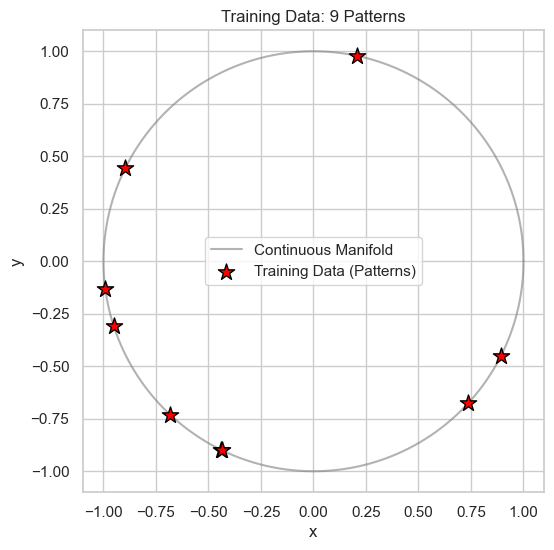

In [5]:
#| echo: false
def plot_circle_data(data, radius=1, figsize=(6, 6)):
    """Helper function to visualize our data on the circle."""
    plt.figure(figsize=figsize)

    # Plot the "continuous manifold" (the full circle)
    theta = np.linspace(0, 2 * np.pi, 200)
    circle_x = radius * np.cos(theta)
    circle_y = radius * np.sin(theta)
    plt.plot(circle_x, circle_y, label='Continuous Manifold', color='gray', alpha=0.6)

    # Plot our training data points ("patterns")
    plt.scatter(data[:, 0], data[:, 1], color='red', s=150, zorder=3, marker="*",
                edgecolor='black', label='Training Data (Patterns)')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Training Data: {len(data)} Patterns')
    plt.legend()
    plt.show()

# Visualize our training data
plot_circle_data(patterns.numpy())

## The Diffusion Model


The diffusion model is simply a model $s_\theta(\mathbf{x}_t, t)$ which approximates the `score` function:
$$
s_\theta(\mathbf{x}_t, t) ≈ \nabla_{\mathbf{x}_t} \log p_t (\mathbf{x}_t)
$$
over a series of timesteps.

In this tutorial, we will be using Variance Exploding `(VE) SDE`, which defines how data is gradually noised over time ranging from $t \in [\epsilon, 1]$:
$$
  \mathrm{d} \mathbf{x}_t = \sigma  \mathrm{d} \mathbf{w}_t
$$
and the corresponding reverse process:
$$
  \mathrm{d} \mathbf{x}_t = \big [ -\sigma^2 \nabla_{\mathbf{x}_t} \log p_t (\mathbf{x}_t) \big ] \mathrm{d}t + \sigma^2 \mathrm{d} \mathbf{w}_t
$$
where $g(t) = \sigma$ is the `diffusion coefficient` and $\mathbf{w}_t$ is `brownian motion`.

In [6]:
class VESDETerms:
    """Defines the terms for the Variance Exploding SDE."""
    def __init__(self, sigma_max, device=None):
        self.sigma = sigma_max
        self.device = device

    def marginal_prob_std(self, t):
        t = torch.as_tensor(t, device=self.device, dtype=torch.float32)
        return self.sigma * torch.sqrt(t)

    def diffusion_coeff(self, t):
        t = torch.as_tensor(t, device=self.device, dtype=torch.float32)
        return self.sigma * torch.ones_like(t)

### ScoreNet Architecture

Our score network is a simple Multi-Layer Perceptron (`MLP`). It takes a noisy data point `x` and a time step `t` as inputs, and returns the `estimated score`. The conditioning on time step `t` is performed via the `Fourier embedding`, a standard method of time conditioning in diffusion models.

In [7]:
#| code-fold: true
#| code-summary: "PyTorch ScoreNet"

@torch.no_grad()
def update_ema(ema_model, model, decay=0.9999):
    """
    Step the EMA model towards the current model.
    """
    ema_params = OrderedDict(ema_model.named_parameters())
    model_params = OrderedDict(model.named_parameters())

    for name, param in model_params.items():
        if param.requires_grad == True:
            ema_params[name].mul_(decay).add_(param.data, alpha=1. - decay)

class FourierEmbedding(torch.nn.Module):
    """Embeds time `t` into a high-dimensional feature space."""
    def __init__(self, embed_dim, scale=16):
        super().__init__()
        self.register_buffer('freqs', torch.randn(embed_dim // 2) * scale)


    def forward(self, x):
        x = x.ger((2. * torch.pi * self.freqs).to(x.dtype))
        x = torch.cat([x.cos(), x.sin()], dim=1)
        return x

class ScoreNet(nn.Module):
    """The score-based model (a simple MLP)."""
    def __init__(
        self,
        input_dim=2,
        num_layers=4,
        hidden_dim=128,
        embed_dim=128,
        marginal_prob_std=None
    ):
        super().__init__()

        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std

        # Time embedding
        self.time_embed = nn.Sequential(
            FourierEmbedding(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim),
            nn.SiLU(),
            nn.Linear(embed_dim, embed_dim),
            nn.SiLU()
        )

        # Project combined (x + time-embedding) to hidden dimension
        self.input_proj = nn.Linear(input_dim + embed_dim, hidden_dim)

        # Hidden MLP layers
        layers = []
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))

            if _ == num_layers - 2:
                layers.append(nn.LayerNorm(hidden_dim))
                layers.append(nn.SiLU())
            else:
                layers.append(nn.SiLU())

        self.hidden = nn.Sequential(*layers)

        # Final output to 2 dimensions
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, x, t):
        # Generate time embedding and concatenate with x
        t_emb = self.time_embed(t)
        h = torch.cat([x, t_emb], dim=1)

        # Pass through MLP
        h = self.input_proj(h)
        h = self.hidden(h)
        h = self.output(h)

        # Scale by 1 / marginal_prob_std(t)
        return h / self.marginal_prob_std(t)[:, None]

## Training

We use the denoising score matching (`DSM`) loss. The goal is to train the `ScoreNet` model so that its output, the score, matches the direction of the noise `z` that was added to the clean data `x` at each time step `t`.
$$
\mathcal{L} = \mathbb{E}_{\mathbf{x}_0, \mathbf{x}_t, t} \, \bigg  [ \lambda(t) \lVert s_\theta (\mathbf{x}_t, t) -  \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t | \mathbf{x}_0) \rVert^2 \bigg ]
$$
where $\mathbf{x}_0$ denotes the clean data point and $\mathbf{x}_t$ is the perturbed data point.

For example, assume $\tilde{\mathbf{x}} \sim \mathcal{N} (\tilde{\mathbf{x}} | \mathbf{x}, \sigma^2 \mathbf{I})$ for the simple case of `DSM`. We have the following:
$$
\nabla_{\tilde{\mathbf{x}}} \log p(\tilde{\mathbf{x}} | \mathbf{x}) = \nabla_\tilde{\mathbf{x}} \bigg ( -\frac{1}{2\sigma^2} (\tilde{\mathbf{x}} - \mathbf{x})^2 \bigg ) = -\frac{\tilde{\mathbf{x}} - \mathbf{x}}{\sigma^2} = -\frac{\mathbf{z}}{\sigma}
$$
as the score function, which we have to learn for a single timestep of denoising. $\mathbf{z} \sim \mathcal{N}(0, \mathbf{I})$.

In [8]:
#| code-fold: true
#| code-summary: "Training Loop and Loss Function"

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The denoising score matching loss function."""
    # Sample a random time t
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps

    # Sample a random noise vector
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)[:, None]

    # Create the noisy data point
    perturbed_x = x + z * std

    # Get the model's score prediction: -z / 𝜎
    score = model(perturbed_x, random_t)

    # Calculate the loss
    loss = torch.mean(torch.square(score * std + z))
    return loss

def train_loop(train_loader, vesde, iterations=100_000, lr=1e-4, device='cuda', log_freq=10_000):
    # create our score model
    score_model = ScoreNet(marginal_prob_std=vesde.marginal_prob_std)

    # create an exponential moving average version of the model
    ema = deepcopy(score_model).to(device)
    score_model = score_model.to(device)

    # create optimizer
    optimizer = torch.optim.Adam(score_model.parameters(), lr=lr)

    # Use an infinite data loader to cycle through our small dataset
    infinite_loader = iter(cycle(train_loader))

    # --- Training ---
    score_model.train()
    running_loss = 0.
    pbar = tqdm(range(iterations))
    for iteration in pbar:
        # Get a batch of data
        x = next(infinite_loader).to(device)

        # Calculate loss
        loss = loss_fn(score_model, x, vesde.marginal_prob_std)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # udpate ema
        update_ema(ema, score_model)

        # Log progress
        if iteration % log_freq == 0 and iteration > 0:
            pbar.set_description(f"Loss: {running_loss / log_freq:.4f}")
            running_loss = 0.

    # return the exponential moving average model
    ema.eval()
    return ema


Time to train! The following code takes a few minutes to run, but the results are cached after the first run.


In [9]:
# Train our SDE-based diffusion models for training data sizes: 2, 9, and 1000.
SEED = 9       # For reproducibility
LR = 1e-4
SIGMA_MAX = 1.
ITERATIONS = 50_000

# Instantiate the SDE and the Model
device = "cuda" if torch.cuda.is_available() else "cpu" 
vesde = VESDETerms(sigma_max=SIGMA_MAX, device=device)

CACHE_MODELS = True

def make_cache_name(sample_size, seed, lr, sigma_max, iterations):
    return f"ema_model_{sample_size}_{seed}_{lr}_{sigma_max}_{iterations}.pth"

def get_ema_model(cache_name):
    cache_path = CACHE_DIR / cache_name
    if cache_path.exists():
        model = ScoreNet(marginal_prob_std=vesde.marginal_prob_std)
        state_dict = torch.load(cache_path)
        model.load_state_dict(state_dict)
        return model
    else:
        return None # Will need to train it

data_sizes = [2, 9, 1000] # Takes ~5 min on an M1 Pro CPU
ema_set, pattern_set = [], [] # store our ema models and training patterns into two separate lists

for sample_size in data_sizes:
    ema = None        
    cache_name = make_cache_name(sample_size, SEED, LR, SIGMA_MAX, ITERATIONS)
    # Extract the training data points for visualization
    batch_size = min(500, sample_size)  # Use all data points in each batch
    train_subset = create_subset(dataset, sample_size, SEED)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

    if CACHE_MODELS:
        ema = get_ema_model(cache_name)
    if ema is None or not CACHE_MODELS: 
        # Train the model if no cache exists
        torch.manual_seed(SEED)
        ema = train_loop(train_loader, vesde, ITERATIONS, LR, device=device)
        torch.save(ema.state_dict(), CACHE_DIR / f"{cache_name}")
        
    patterns = train_subset.dataset[train_subset.indices]
    pattern_set.append(patterns)
    ema_set.append(ema)

## Sampling from the Trained Model

To generate new samples, we run the diffusion process in reverse. We start with pure random noise (sampled at `t=1`) and use our trained score model to guide it back towards the data distribution (towards `t=0`). This is done using a numerical SDE solver, like the [Euler-Maruyama method](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method).


In [10]:
#| code-fold: true
#| code-summary: "Euler-Maruyama Sampler"

def Euler_Maruyama_sampler(score_model,
                           sde,
                           batch_size=64,
                           num_steps=1000,
                           device='cuda',
                           eps=1e-5):
    """Generate samples from the score-based model using the Euler-Maruyama solver."""
    score_model.eval()
    t_end = torch.ones(batch_size, device=device)

    # Start with orthogonalized random noise ~ N(0, sigma_max^2 * I)
    init_x = torch.randn(batch_size, 2, device=device)
    init_x = init_x  / torch.norm(init_x, dim = (1), keepdim=True)
    init_x = init_x * sde.marginal_prob_std(t_end)[:, None]

    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1] #dt
    x = init_x

    with torch.no_grad():
        for time_step in tqdm(time_steps, desc="Sampling"):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = sde.diffusion_coeff(batch_time_step)
            # This is the reverse SDE update step
            mean_x = x + (g**2)[:, None] * score_model(x, batch_time_step) * step_size
            eps = torch.randn_like(x)
            noise = torch.sqrt(step_size) * g[:, None] * eps
            x = mean_x + noise

    score_model.train()
    return mean_x # Return the final denoised sample

We can now sample from the trained models.

In [11]:
#| code-fold: true
#| code-summary: "Sampling from the Trained Models"
generated_set = []

for ema in ema_set:
    generated_samples = Euler_Maruyama_sampler(ema, vesde, batch_size=1_500, device=device)
    generated_samples = generated_samples.detach().cpu().numpy()
    generated_set.append(generated_samples)

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

## Potential Energy of Generated and Data Samples

Recall the relationship between energy and probability denoted by the `Boltzmann distribution`:
$$
    p_\theta(\mathbf{x}) = \frac{\exp{(-E_\theta(\mathbf{x}))} }{Z_\theta}
$$
This indicates that our energy (up to a constant) is obtained by computing the negative log-likelihood:
$$
    -\log p_\theta(\mathbf{x}) = E_\theta(\mathbf{x}) + C
$$

Since we are dealing with a non-equilibrium system, that is our diffusion model, we follow the formulations and codes provided in [Song et al. (2021)](https://arxiv.org/abs/2011.13456) to compute the log-likelihood:
$$
    \log p_0(\mathbf{x}_0;\mathbf{\theta}) = \log p_T(\mathbf{x}_T; \theta) + \int_0^T \nabla \cdot \tilde{\mathbf{f}}(\mathbf{x}_t, t)  \mathrm{d}t
$$
where
$$
    \tilde{\mathbf{f}}(\mathbf{x}_t, t) =-\frac{1}{2}\sigma^2 \nabla_{\mathbf{x}_{t}} \log p_t(\mathbf{x}_{t}; \theta)
$$
for this setting. Keep in mind, $\nabla \cdot ()$ denotes the laplacian operation.

To derive the above equation, we start with the `Fokker-Planck` equation, as did in [Chen et al. (2018)](https://arxiv.org/abs/1806.07366) and [Song et al. (2021)](https://arxiv.org/abs/2011.13456), which yields the following general probability flow ODE (derived from the forward process SDE):
$$
    \mathrm{d} \mathbf{x}_t = \tilde{\mathbf{f}}(\mathbf{x}_t, t)\mathrm{d} t + \tilde{\mathbf{g}} (\mathbf{x}_t, t) \mathrm{d} \mathbf{w}_t
$$
where
$$\tilde{\mathbf{f}}(\mathbf{x}_t, t) = \mathbf{f} (\mathbf{x}_t, t) - \frac{1}{2} \nabla \cdot \big[\mathbf{g} (\mathbf{x}_t, t) \mathbf{g} (\mathbf{x}_t, t)^\top \big] - \frac{1}{2}  \big [ \mathbf{g} (\mathbf{x}_t, t) \mathbf{g} (\mathbf{x}_t, t)^\top \big ] \nabla_{\mathbf{x}_t} \log p_t(\mathbf{x}_t)$$
and $\tilde{\mathbf{g}} (\mathbf{x}_t, t) = 0$.


Here, $\mathbf{f}(\mathbf{x}_t, t) = 0$ denotes the drift term which vanishes in the VE setting while $\mathbf{g} (\mathbf{x}_t, t) = \sigma$ which is constant in this setting. Thus, the probability flow ODE for our setting is simply:
$$
    \mathrm{d} \mathbf{x}_t = \tilde{\mathbf{f}}(\mathbf{x}_t, t)\mathrm{d} t = -\frac{1}{2}\sigma^2 \nabla_{\mathbf{x}_{t}} \log p_t(\mathbf{x}_{t}) \, \mathrm{d}t
$$


In [12]:
#| code-fold: true
#| code-summary: "Computing the Laplacian and Log-Likelihood"
# @title Code to Compute Laplacian and Log-Likelihood
def compute_laplacian(score_fn, x, t):
    """
    Compute the Laplacian of the score function using torch.func utilities.
    This is a more efficient, vectorized alternative to the loop-based approach.
    """

    def get_laplacian_for_single_sample(x_sample, t_sample):
        """
        A helper function that computes the Laplacian for one sample.
        This is the function we will vectorize using vmap (like Jax).
        """
        # We have to unsqueeze since torch module requires a batch dim.
        f = lambda x_inp: score_fn(x_inp[None], t_sample[None]).squeeze(0)

        # Compute the Jacobian of the score function w.r.t. x.
        # This gives a D x D matrix where D is the dimension of x.
        J = torch.func.jacrev(f)(x_sample)

        # The Laplacian is the trace of the Jacobian matrix (sum of its diagonal).
        return torch.trace(J)

    # Apply vmap over the first dimension for both inputs
    return torch.func.vmap(get_laplacian_for_single_sample, in_dims=(0, 0))(x, t)


def ode_likelihood_with_laplacian(x, score_model, sde, device='cuda', eps=1e-5):
    """Compute the log-likelihood of x by solving the probability flow ODE."""
    shape = x.shape

    def score_eval_wrapper(sample, time_steps):
        """A wrapper for evaluating the score-based model for the ODE solver."""
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
        time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
        with torch.no_grad():
            score = score_model(sample, time_steps)
        return score.cpu().numpy().reshape((-1, shape[1])).astype(np.float64)

    def laplacian_eval_wrapper(sample, time_steps):
        """A wrapper for evaluating the Laplacian of the score function."""
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
        time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
        laplacian = compute_laplacian(score_model, sample, time_steps)
        return laplacian.cpu().numpy().reshape((-1,)).astype(np.float64)

    def ode_func(t, x_and_logp):
        time_steps = torch.from_numpy(np.ones((shape[0],)) * t).to(device, torch.float32)
        sample = torch.from_numpy(x_and_logp[:-shape[0]].reshape(shape)).to(device, torch.float32)

        with torch.no_grad():
            g = sde.diffusion_coeff(time_steps).cpu().numpy()

            score = score_eval_wrapper(sample, time_steps)
            laplacian = laplacian_eval_wrapper(sample, time_steps)

        drift = -0.5 * g[:, None]**2 * score
        logp_grad = -0.5 * g**2 * laplacian
        return np.concatenate([drift.flatten(), logp_grad], axis = 0)

    init = np.concatenate([x.cpu().numpy().flatten(), np.zeros((shape[0],))])
    res = integrate.solve_ivp(ode_func, (eps, 1.), init, rtol=1e-5, atol=1e-5, method='RK45')
    zp = torch.tensor(res.y[:, -1], device=device)
    z = zp[:-shape[0]].reshape(shape)
    delta_logp = zp[-shape[0]:]

    sigma_max = sde.marginal_prob_std(torch.tensor(1.))

    prior_logp = -shape[1] / 2. * torch.log(2 * np.pi * sigma_max ** 2)
    prior_logp = prior_logp - torch.sum(z ** 2, dim=-1) / (2 * sigma_max ** 2)
    return (prior_logp + delta_logp)

### Visualizing the Energy


Since we are generating quite a lot of synthetic data points, we use `hierarchical clustering` to get a sense of where the concentrations of these new points are at. To be more informative, we are also displaying the energy profile of these concentrations alongside that of the training data points.

At `K = 2`, we can see that the concentrations of generated points are pretty much surrounding the data points and their energy profile are similar to that of the training data points.

Meanwhile, at `K = 9`, we now see local minima of the energy that devitate drastically from the training points. These new local minima of the energy are called `spurious patterns`.

Finally, when `K = 1000`, the energy now very closely matches that of the DenseAM's derived `exact energy`, see below.

In [13]:
#| code-fold: true
#| code-summary: "Plot Functions for Energy Landscape in 2D and 3D"
# @title Plot Functions for Energy Landscape in 2D and 3D

def to_energy(loglikelihood, normalize=True):
    # nll = E + C
    energy = -loglikelihood
    if normalize:
         # normalize energy by its minimum
        return energy - energy.min()
    return energy


def plot_combined_landscape(fig, ax, score_model, sde, patterns, samples, labels, centers, t_eval=1e-5, device='cpu', annotate=True, quiver_stride=10):
    """Visualize the energy landscape with annotated points."""
    score_model.eval()

    # 1. Calculate Energy for Patterns and Centers
    # Energy for original patterns
    patterns_tensor = patterns.to(device)
    logp_patterns = ode_likelihood_with_laplacian(patterns_tensor, score_model, sde, device, eps=t_eval)
    energy_patterns = to_energy(logp_patterns).cpu().numpy()

    # Energy for found cluster centers
    centers_tensor = torch.from_numpy(centers).float().to(device)
    logp_centers = ode_likelihood_with_laplacian(centers_tensor, score_model, sde, device, eps=t_eval)
    energy_centers = to_energy(logp_centers).cpu().numpy()

    # 2. Create a grid of points
    bounds=(-1.5, 1.5); resolution=75
    x_ = torch.linspace(bounds[0], bounds[1], resolution)
    y_ = torch.linspace(bounds[0], bounds[1], resolution)
    X, Y = torch.meshgrid(x_, y_, indexing='ij')
    grid_tensor = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)

    # 3. Calculate the energy and score for the grid
    logp_grid = ode_likelihood_with_laplacian(grid_tensor, score_model, sde, device, eps=t_eval)
    energy_grid = to_energy(logp_grid).cpu().numpy().reshape(resolution, resolution)

    with torch.no_grad():
        vec_t = torch.ones(grid_tensor.shape[0], device=device) * t_eval
        scores = score_model(grid_tensor, vec_t).cpu().numpy()

    # 4. Create the comprehensive plot
    ax.set_title(f'K = {len(patterns)}', fontsize=7.5, pad=-0.025)
    ax.set_aspect('equal'); ax.grid(False)

    # Plot energy contour
    contour = ax.contourf(X.cpu(), Y.cpu(), energy_grid, levels=100, cmap='inferno', zorder=0)

    # Plot the unit circle
    theta = np.linspace(0, 2 * np.pi, 200)
    ax.plot(np.cos(theta), np.sin(theta), color='white', linestyle='--', alpha=0.6, zorder=1, label='Unit Circle')

    # Plot score field
    ax.quiver(grid_tensor[:, 0].cpu()[::quiver_stride], grid_tensor[:, 1].cpu()[::quiver_stride],
              scores[:, 0][::quiver_stride], scores[:, 1][::quiver_stride], color='white', alpha=0.5,
              width=0.005, headwidth=3, zorder=2)

    # Plot original patterns
    ax.scatter(patterns[:, 0].cpu(), patterns[:, 1].cpu(), marker="*", alpha=0.75,
               s=100, color="deeppink", label="Original Patterns", edgecolor='black', zorder=5)

    if annotate: # turn off annotation and plotting center since there are too many patterns at this point
        # Plot generated samples
        ax.scatter(samples[:, 0], samples[:, 1], c=labels, cmap='viridis',
                   s=7.5, alpha=0.2, zorder=3, label='Generated Samples')

        # Plot found cluster centers
        ax.scatter(centers[:, 0], centers[:, 1], marker='X', s=40,
                    color='aqua', edgecolor='black', zorder=4, label='Cluster Centers')

        # Add energy annotations for patterns
        for i, p in enumerate(patterns.cpu().numpy()):
            ax.annotate(f'{energy_patterns[i]:.2f}', (p[0], p[1]),
                        xytext=(10, 0), textcoords='offset points', color='deeppink', fontsize=4,
                        weight='bold', bbox=dict(boxstyle="round,pad=0.2", fc="black", ec="lime", lw=1, alpha=0.6))

        # Add energy annotations for cluster centers
        for i, c in enumerate(centers):
            ax.annotate(f'{energy_centers[i]:.2f}', (c[0], c[1]),
                        xytext=(-15, 0), textcoords='offset points', color='aqua', fontsize=4,
                        weight='bold', bbox=dict(boxstyle="round,pad=0.2", fc="black", ec="yellow", lw=1, alpha=0.6))

    #ax.set_xlabel('x', fontsize=5.5); ax.set_ylabel('y', fontsize=5.5);
    ax.set_xticks([]); ax.set_yticks([]);
    ax.set_xlim(bounds); ax.set_ylim(bounds);
    return contour


def plot_energy_surface_3d(fig, ax, X, Y, energy, view_angle=(60, -60), title=None):
    """
    Creates a 3D surface plot of the energy landscape.

    Args:
        X (np.ndarray): Meshgrid for X coordinates.
        Y (np.ndarray): Meshgrid for Y coordinates.
        energy (np.ndarray): 2D array of energy values.
        view_angle (tuple): Tuple of (elevation, azimuth) for the plot's camera angle.
    """
    # Plot the 3D surface
    surface = ax.plot_surface(X, Y, energy, cmap='inferno', rstride=1, cstride=1,
                              linewidth=0, antialiased=True, alpha=0.9)

    # Set labels and title
    ax.set_xlabel('x', fontsize=5, labelpad=-18)
    ax.set_ylabel('y', fontsize=5, labelpad=-18)
    ax.set_zlabel('Energy', fontsize=5, labelpad=-18, rotation=-90)
    ax.set_title(title, fontsize=7.5, y=-0.08)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    # Set a nice viewing angle
    ax.view_init(elev=view_angle[0], azim=view_angle[1])
    return surface

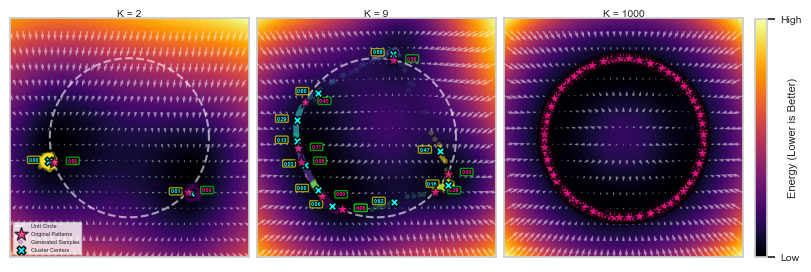

In [14]:
#| echo: false
# @title Visualization of the Energy Landscape Across K training Sizes in 2D
# This threshold determines how close points need to be to be considered in the same cluster.
# You may need to tune this value based on your results.
dist_thresholds = [3, 2, 0.45]
annotates = [True, True, False]
t_evals = [0.15] * len(dist_thresholds) # evaluate potentials at eps = 0.15

fig, axs = plt.subplots(1, 3, figsize=(8, 8), constrained_layout=True)
for i, (patterns, generated_samples, ema, threshold, t_eval, annotate) in enumerate(zip(pattern_set, generated_set, ema_set, dist_thresholds, t_evals, annotates)):
    # Perform Agglomerative (Hierarchical) Clustering
    clustering = AgglomerativeClustering(
        n_clusters=None,                                      # We let the algorithm find the clusters based on the threshold
        distance_threshold=threshold
    ).fit(generated_samples)

    # Find the center of each identified cluster
    cluster_labels = clustering.labels_
    n_clusters_found = len(np.unique(cluster_labels))

    cluster_centers = np.array([
        generated_samples[cluster_labels == i].mean(axis=0)
        for i in range(n_clusters_found)
    ])

    contour = plot_combined_landscape(
        fig, axs[i],
        ema,
        vesde,
        patterns,
        generated_samples,
        cluster_labels,
        cluster_centers,
        device=device,
        t_eval=t_eval,
        annotate=annotate,
    )

axs[0].legend(loc='lower left', fontsize=4)

# Set the ticks to only be at the min and max
cbar = fig.colorbar(contour, ax=axs[-1], shrink=0.3)
cbar.set_label('Energy (Lower is Better)', fontsize=8, labelpad=-10)
vmin, vmax = contour.get_clim()
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels(['Low', 'High'], fontsize=7.5)
plt.show()

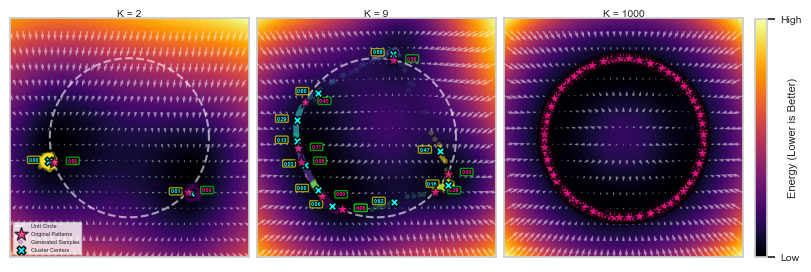

In [15]:
#| code-fold: true
#| code-summary: "Visualization of the Energy Landscape Across K training Sizes in 2D"
# This threshold determines how close points need to be to be considered in the same cluster.
# You may need to tune this value based on your results.
dist_thresholds = [3, 2, 0.45]
annotates = [True, True, False]
t_evals = [0.15] * len(dist_thresholds) # evaluate potentials at eps = 0.15

fig, axs = plt.subplots(1, 3, figsize=(8, 8), constrained_layout=True)
for i, (patterns, generated_samples, ema, threshold, t_eval, annotate) in enumerate(zip(pattern_set, generated_set, ema_set, dist_thresholds, t_evals, annotates)):
    # Perform Agglomerative (Hierarchical) Clustering
    clustering = AgglomerativeClustering(
        n_clusters=None,                                      # We let the algorithm find the clusters based on the threshold
        distance_threshold=threshold
    ).fit(generated_samples)

    # Find the center of each identified cluster
    cluster_labels = clustering.labels_
    n_clusters_found = len(np.unique(cluster_labels))

    cluster_centers = np.array([
        generated_samples[cluster_labels == i].mean(axis=0)
        for i in range(n_clusters_found)
    ])

    contour = plot_combined_landscape(
        fig, axs[i],
        ema,
        vesde,
        patterns,
        generated_samples,
        cluster_labels,
        cluster_centers,
        device=device,
        t_eval=t_eval,
        annotate=annotate,
    )

axs[0].legend(loc='lower left', fontsize=4)

# Set the ticks to only be at the min and max
cbar = fig.colorbar(contour, ax=axs[-1], shrink=0.3)
cbar.set_label('Energy (Lower is Better)', fontsize=8, labelpad=-10)
vmin, vmax = contour.get_clim()
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels(['Low', 'High'], fontsize=7.5)
plt.show()

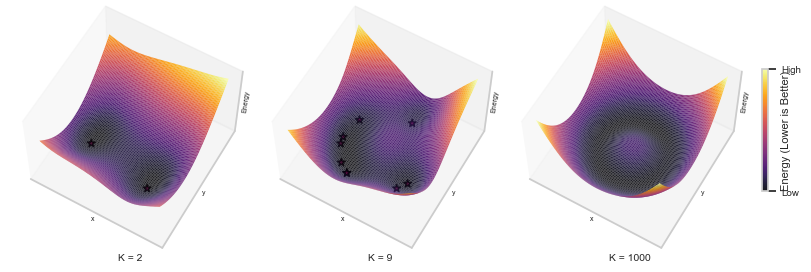

In [ ]:
#| code-fold: true
#| code-summary: "Visualization of the Energy Landscape Across K training Sizes in 3D"
# This code is slow to run, so we cache the figure
CACHE_FIG = True

bounds = (-1.5, 1.5)
resolution = 100
X_grid, Y_grid = torch.meshgrid(
    torch.linspace(bounds[0], bounds[1], resolution),
    torch.linspace(bounds[0], bounds[1], resolution),
    indexing='ij'
)
grid_tensor = torch.stack([X_grid.ravel(), Y_grid.ravel()], dim=1).to(device)

fig_fname = CACHE_DIR / "slow_fig.png"
if CACHE_FIG and fig_fname.exists():
    img = Image.open(str(fig_fname))
    display(img)
else:
    fig, axs = plt.subplots(1, 3, figsize=(8, 6), constrained_layout=True, subplot_kw={"projection": "3d"})

    for i, (patterns, score_model, annotate, eps) in enumerate(zip(pattern_set, ema_set, annotates, t_evals)):
        # Calculate the energy for the grid (this is the slow step)
        logp_grid = ode_likelihood_with_laplacian(grid_tensor, score_model, vesde, device=device, eps=eps)
        energy_grid = to_energy(logp_grid).cpu().numpy()
        energy_grid = energy_grid.reshape(resolution, resolution)

        # Create the plot
        contour = plot_energy_surface_3d(fig, axs[i], X_grid.cpu().numpy(), Y_grid.cpu().numpy(), energy_grid, title=f'K = {len(patterns)}')

        # show the data points again...
        if annotate:
            axs[i].scatter(
                patterns[:, 0].cpu(), patterns[:, 1].cpu(), marker="*", alpha=0.75,
                s=35, color="deeppink", label="Original Patterns", edgecolor='black', zorder=5
            )

    # Set the ticks to only be at the min and max
    cbar = fig.colorbar(contour, ax=axs[-1], shrink=0.25)
    cbar.set_label('Energy (Lower is Better)', fontsize=8, labelpad=-15)

    vmin, vmax = contour.get_clim()
    cbar.set_ticks([vmin, vmax])

    cbar.set_ticklabels(['Low', 'High'], fontsize=7)
    plt.savefig(fig_fname)

plt.show()

# Exact Energy from Dense Associative Memory

Consider the typical `DenseAM`'s energy function which involves the `logsumexp` function:
$$
E^\text{AM}(\mathbf{x}) = -\beta^{-1} \log \bigg[\sum\limits_{\mu=1}^K \exp\Big(- \beta \lVert \mathbf{x} - \boldsymbol{\xi}^\mu \rVert^2_2\Big) \bigg]
$$
which is related to the energy of the diffusion model, derived in our [work](https://arxiv.org/abs/2505.21777):
$$
E^\text{DM}(\mathbf{x}_t, t) = -2 \sigma^2 t \log\bigg[\sum\limits_{\mu=1}^K \exp \Big(- \frac{\lVert \mathbf{x}_t - \boldsymbol{\xi}^\mu \rVert^2_2}{2 \sigma^2 t}\Big) \bigg]
$$

Both of these energies expressed competitions among the memories (or stored data patterns). But, the main difference is in the value of the `inverse temperature` $\beta$. In the case of diffusion models, it is alternating over time, i.e., $\beta_t = \frac{1}{2 \sigma^2 t}$, but for DenseAM, this variable is fixed. Nonetheless, although their dynamical trajetories are slightly different, the fixed points (obtained at $t \approx 0$) of both equations are still the same.

Using DenseAM energy, for the case of $K = 2$, we have the following:
$$
E^\text{AM}(\mathbf{x}) = -\beta^{-1} \log \Big[\exp \Big(- \beta \lVert \mathbf{x} - \boldsymbol{\xi}^1 \rVert^2_2\Big) + \exp \Big(- \beta \lVert \mathbf{x} - \boldsymbol{\xi}^2 \rVert^2_2 \Big) \Big]
$$

For small finite values of $\beta$, it is possible for a minimum to exist:
$$
\boldsymbol{\eta} = \underset{\mathbf{x}}{\text{arg min}} \, E^\text{AM}(\mathbf{x})
$$
such that $\boldsymbol{\eta} \neq \xi^1$ and $\boldsymbol{\eta} \neq \xi^2$. This minimum is the `spurious pattern`.

Assume that the empirical data distribution is $p(\mathbf{y}) = \frac{1}{K}\sum\limits_{\mu=1}^K \delta^{(N)}(\mathbf{y} - \boldsymbol{\xi}^\mu)$ where $\boldsymbol{\xi}^\mu$ represents an individual data point (with data size $K$).

When the training data size $K \rightarrow \infty$, this `empirical data distirbution` becomes a continuous density of states:
$$
p(\mathbf{y}) = \frac{1}{\pi} \delta\big(y_1^2+y_2^2-1\big)
$$
The probability of the generated data is then proportional (up to terms independent of the state $\mathbf{x}$) to
$$
p(\mathbf{x}) \sim \int\limits_{-\infty}^{+\infty} dy_1 dy_2\ p(\mathbf{y})\ e^{- \beta \lVert \mathbf{x} - \mathbf{y} \rVert^2_2} = e^{-\beta (R^2+1)} I_0(2\beta R)
$$
where $I_0(\cdot)$ is a `modified Bessel function` of the first kind and $R$ is the radius of the circle. Then, the exact energy of our toy model is the following:
$$
E^\text{AM}(R, \phi) =  R^2+1 - \frac{1}{\beta} \log\big[I_0(2\beta R)\big] \underset{\beta\rightarrow\infty}{\approx} (R - 1)^2
$$
given the polar angle $\phi$.


## The Empirical Energy and Score Function for the Toy Model

In [17]:
def cartesian_to_polar(samples):
    x, y = samples[:, 0], samples[:, 1]
    r = np.sqrt(x ** 2 + y ** 2)
    angles = np.arctan2(y, x)
    return r, angles

def energy_am(samples, beta, normalize=True):
    """
    Computes the energy function
        E^AM(R, phi) = R^2 + 1 - (1 / beta) * log(I_0(2 * beta * R))

    See Eq. (13) in the paper.
    """
    r, _ = cartesian_to_polar(samples)
    energy = r**2 + 1 - (1 / beta) * np.log(i0(2 * beta * r))

    # Shift so that the lowest energy is
    if normalize:
        energy = energy - energy.min()
    return energy

def score_am(samples, beta, epsilon=1e-6):
    """
    Computes the score function
        S^AM(R, phi) = -2 * R - (2 / beta) * I_1(2 * beta * R) / I_0(2 * beta * R)

    See Eq. (18) in the paper.
    """
    r, _ = cartesian_to_polar(samples)

    # Ensure r is not zero to avoid division by zero
    r = np.clip(r, epsilon, np.inf)

    bessel_ratio = i1(2 * beta * r) / i0(2 * beta * r)

    score_r = 2 * (bessel_ratio - r)
    score = score_r[:, None] * samples / r[:, None]

    return score

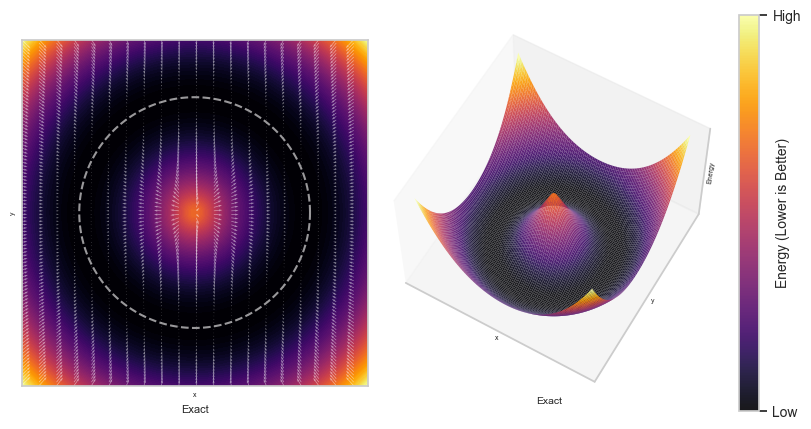

In [18]:
#| code-fold: true
#| code-summary: "Visualization of the Empirical Energy Landscape and its Score Function"
# @title Visualization of the Empirical Energy Landscape and its Score Function
# Inverse Temperature -- Beta
beta = 1 / 0.05

grid_square = torch.stack([X_grid, Y_grid], dim=1)
scores = score_am(grid_square, beta)
energy = energy_am(grid_square, beta)
energy_grid = energy.reshape(resolution, resolution)

fig = plt.figure(figsize=(8, 8), constrained_layout=True)

ax = fig.add_subplot(121)
ax.set_title('Exact', fontsize=8, y=-0.1)
ax.set_aspect('equal'); ax.grid(False)

# Plot energy contour
contour = ax.contourf(X_grid.cpu(), Y_grid.cpu(), energy_grid, levels=100, cmap='inferno', zorder=0)

# Plot the unit circle
theta = np.linspace(0, 2 * np.pi, 200)
ax.plot(np.cos(theta), np.sin(theta), color='white', linestyle='--', alpha=0.6, zorder=1, label='Unit Circle')


stride = 5
# Plot score field
ax.quiver(grid_square[:, 0].cpu()[::stride], grid_square[:, 1].cpu()[::stride],
          scores[:, 0][::stride], scores[:, 1][::stride], color='white', alpha=0.5,
          width=0.002, headwidth=3, zorder=2)

ax.set_xlabel('x', fontsize=5)
ax.set_ylabel('y', fontsize=5)
ax.set_xticks([]); ax.set_yticks([]);

ax = fig.add_subplot(122, projection="3d")
contour = plot_energy_surface_3d(fig, ax, X_grid, Y_grid, energy_grid, view_angle=(60, -60), title='Exact')

cbar = fig.colorbar(contour, ax=ax, shrink=0.5)
cbar.set_label('Energy (Lower is Better)', fontsize=10, labelpad=-18)

vmin, vmax = contour.get_clim()
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels(['Low', 'High'], fontsize=10)
plt.show()